# Journal 2022-08-26
Topological Data Analysis for time series data using [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/time_series_forecasting.html)

## Links
* [nbdev "The JuPyter+Git Problem is Solved"](https://www.fast.ai/2022/08/25/jupyter-git/) (via [Hacker News](https://news.ycombinator.com/item?id=32601703)) - haven't tried this out yet as it fiddles with git but might do on new repo.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import gtda

In [3]:
from ftse_constituents import get_sector_history, DATA_DIR

Read sector data and cache.  Probably worth turning this into a general cache decorator if there isn't already one in Python library (googles) - ah [Cache to Disk](https://pypi.org/project/cache-to-disk/) might be worth a look.

In [4]:
sector_price_file = os.path.join(DATA_DIR, 'sector_prices.pkl')
if os.path.isfile(sector_price_file):
    print('Loading from cache')
    df_p = pd.read_pickle(sector_price_file)
else:
    print('Retrieving from Yahoo Finance')
    df_p = get_sector_history()
    df_p.to_pickle(sector_price_file)

Loading from cache


Follow the example [Topology in time series forecasting](Topology in time series forecasting) from the Giotto TDA doc but use some sector financial data.

In [5]:
df_X = df_p.loc[:, ('Adj Close', ['IUCD.L', 'IUFS.L'])]
df_y = df_p.loc[:, ('Adj Close', 'IUIT.L')]

In [6]:
df_X.head()

Adj Close         
              IUCD.L   IUFS.L
Date                         
2015-11-20   5.06539  5.01332
2015-11-23   5.08300  4.99410
2015-11-24   5.05375  4.95350
2015-11-25   5.09125  4.97850
2015-11-26   5.12125  5.00325

In [7]:
df_y.head()

Date
2015-11-20    5.06000
2015-11-23    5.03830
2015-11-24    5.01875
2015-11-25    5.02625
2015-11-26    5.04375
Name: (Adj Close, IUIT.L), dtype: float64

In [8]:
from gtda.time_series import SlidingWindow

In [9]:
window_size = 3
stride = 2
sw = SlidingWindow(size=window_size, stride=stride)

In [10]:
# Sliding Window seems to work on pd.DataFrame and pd.Series
X_sw, yr = sw.fit_transform_resample(df_X, df_y)

In [11]:
df_X.iloc[:6, :], df_X.shape, X_sw[0:2, ...], X_sw.shape,

(           Adj Close         
               IUCD.L   IUFS.L
 Date                         
 2015-11-20   5.06539  5.01332
 2015-11-23   5.08300  4.99410
 2015-11-24   5.05375  4.95350
 2015-11-25   5.09125  4.97850
 2015-11-26   5.12125  5.00325
 2015-11-27   5.08125  4.99750,
 (1710, 2),
 array([[[5.08300018, 4.99410009],
         [5.05375004, 4.95349979],
         [5.09124994, 4.97849989]],
 
        [[5.09124994, 4.97849989],
         [5.12125015, 5.00325012],
         [5.08125019, 4.99749994]]]),
 (854, 3, 2))

We see that the DataFrame length isn't a multiple of the stride size so the first window starts at an offset skipping the oldest data i.e. prioritises keeping most recent data.



In [12]:
df_y.head(8), yr.shape, yr[:3]

(Date
 2015-11-20    5.06000
 2015-11-23    5.03830
 2015-11-24    5.01875
 2015-11-25    5.02625
 2015-11-26    5.04375
 2015-11-27    5.03875
 2015-11-30    5.03375
 2015-12-01    5.06875
 Name: (Adj Close, IUIT.L), dtype: float64,
 (854,),
 array([5.02624989, 5.03875017, 5.0687499 ]))

We see that the resampled target data is aligned with the windowed feature data e.g. first window is from 2015-11-23 to 2015-11-25, first y value is from 2015-11-25

In [14]:
dates = sw.fit_transform(df_X.index)[:, -1]
dates[:5]

array(['2015-11-25T00:00:00.000000000', '2015-11-27T00:00:00.000000000',
       '2015-12-01T00:00:00.000000000', '2015-12-03T00:00:00.000000000',
       '2015-12-07T00:00:00.000000000'], dtype='datetime64[ns]')

In [15]:
from gtda.time_series import PearsonDissimilarity
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude

In [16]:
features = ['IUCD.L', 'IUFS.L']
target = 'IUIT.L'
df_r = df_p.loc[:, ('Adj Close', features + [target])].pct_change().dropna()
df_X_r = df_r.loc[:, ('Adj Close', features)]
df_y_r = df_r.loc[:, ('Adj Close', target)]

In [17]:
df_X_r.head()

Adj Close          
              IUCD.L    IUFS.L
Date                          
2015-11-23  0.003477 -0.003834
2015-11-24 -0.005755 -0.008130
2015-11-25  0.007420  0.005047
2015-11-26  0.005893  0.004971
2015-11-27 -0.007811 -0.001149

In [18]:
df_y_r.head()

Date
2015-11-23   -0.004289
2015-11-24   -0.003880
2015-11-25    0.001494
2015-11-26    0.003482
2015-11-27   -0.000991
Name: (Adj Close, IUIT.L), dtype: float64

In [26]:
# Monthly correlation estimation, weekly stride
SW = SlidingWindow(size=21, stride=5)
X_sw, y_rs = SW.fit_transform_resample(df_X_r, df_y_r)

In [27]:
X_sw.shape, y_rs.shape

((338, 21, 2), (338,))

In [28]:
PD = PearsonDissimilarity()
X_pd = PD.fit_transform(X_sw)
X_pd.shape, X_pd[0, ...], # 1-np.corrcoef(X_pd[0, ...])

((338, 2, 2),
 array([[0.00000000e+00, 4.25025725e-02],
        [4.25025725e-02, 5.55111512e-17]]))

In [29]:
# Takes about 1 minute for 338 windows.  These only have 2 sectors, how does this scale?
# Also, this means only 2 points so we won't get that interesting homology in d > 0 
VR = VietorisRipsPersistence(metric="precomputed")
X_vr = VR.fit_transform(X_pd)  # "precomputed" required on dissimilarity data
X_vr.shape, X_vr[:2, ...] 

((338, 2, 3),
 array([[[5.55111512e-17, 4.25025709e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],
 
        [[5.55111512e-17, 2.68771052e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]]))

In [30]:
Ampl = Amplitude()
X_a = Ampl.fit_transform(X_vr)
X_a.shape

(338, 2)

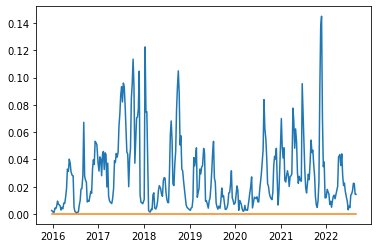

In [31]:
dates = SW.fit_transform(df_X_r.index)[:, -1]
_ = plt.plot(dates, X_a)

Continue following the example and make a SciKit Learn pipeline

In [32]:
from sklearn import set_config
set_config(display='diagram')  # For HTML representations of pipelines

from gtda.pipeline import make_pipeline

pipe = make_pipeline(SW, PD, VR, Ampl)
pipe

Pipeline(steps=[('slidingwindow', SlidingWindow(size=21, stride=5)),
                ('pearsondissimilarity', PearsonDissimilarity()),
                ('vietorisripspersistence',
                 VietorisRipsPersistence(metric='precomputed')),
                ('amplitude', Amplitude())])

In [38]:
pipe.fit_transform(df_X_r)[:10, :]

array([[0.00251157, 0.        ],
       [0.00130139, 0.        ],
       [0.00112689, 0.        ],
       [0.00418803, 0.        ],
       [0.00390594, 0.        ],
       [0.0055068 , 0.        ],
       [0.00940379, 0.        ],
       [0.00718857, 0.        ],
       [0.0066638 , 0.        ],
       [0.00578726, 0.        ]])

In [36]:
# Agrees with original 
X_a[:10,:]

array([[0.00251157, 0.        ],
       [0.00130139, 0.        ],
       [0.00112689, 0.        ],
       [0.00418803, 0.        ],
       [0.00390594, 0.        ],
       [0.0055068 , 0.        ],
       [0.00940379, 0.        ],
       [0.00718857, 0.        ],
       [0.0066638 , 0.        ],
       [0.00578726, 0.        ]])

# Topological Features in Sector Returns
Try for a wider range of indexes.  Exclude Communications sector since the ETF only becomes available in September 2018.  Could exclude others to increase range.

In [91]:
df_p.loc[:, 'Adj Close'].isna().cumsum().max().apply(lambda x: df_p.index[x]).sort_values()

IUCD.L   2015-11-20
IUES.L   2015-11-20
IUFS.L   2015-11-20
IUHC.L   2015-11-20
IUIT.L   2015-11-20
IUCS.L   2017-03-22
IUIS.L   2017-03-22
IUMS.L   2017-03-22
IUUS.L   2017-03-22
IUCM.L   2018-09-17
dtype: datetime64[ns]

In [41]:
df_a_r = df_p['Adj Close'].pct_change().drop(columns=['IUCM.L']).dropna()
df_a_r.head()

,IUCD.L,IUCS.L,IUES.L,IUFS.L,IUHC.L,IUIS.L,IUIT.L,IUMS.L,IUUS.L
Date,,,,,,,,,
2017-03-23,0.007299,-0.002503,0.007707,0.011609,0.003795,-0.001521,0.003226,0.004486,-0.002432
2017-03-24,0.000000,-0.002610,-0.007648,-0.004918,-0.003781,-0.002762,0.001608,-0.009334,0.004024
2017-03-27,-0.003623,-0.000644,-0.005780,-0.013180,0.000000,-0.006638,-0.008026,-0.001909,-0.006930
2017-03-28,0.005909,0.000604,0.007752,0.018364,-0.001897,0.011069,0.006472,0.014851,0.001988
2017-03-29,0.006778,0.003221,0.015385,-0.003279,0.005703,0.001723,0.004823,0.003809,-0.000744


In [42]:
X_topological_features = pipe.fit_transform(df_a_r)
X_topological_features[:5, ...]

array([[0.04917986, 0.        ],
       [0.06073479, 0.        ],
       [0.05846621, 0.        ],
       [0.04017076, 0.        ],
       [0.03574353, 0.        ]])

In [47]:
feature_dates = pipe.steps[0][1].fit_transform(df_a_r.index)[:, -1]

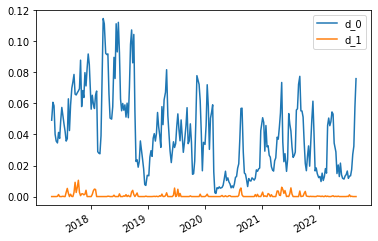

In [92]:
df_t = pd.DataFrame(X_topological_features, index=feature_dates, columns=['d_0', 'd_1'])
_ = df_t.plot()

Combine with the weekly sector returns (matches SlidingWindow size)

In [93]:
df_a_t = df_a_r.rolling('5D').sum().join(df_t).dropna()
df_a_t.head()

,IUCD.L,IUCS.L,IUES.L,IUFS.L,IUHC.L,IUIS.L,IUIT.L,IUMS.L,IUUS.L,d_0,d_1
Date,,,,,,,,,,,
2017-04-25,0.013313,0.011457,0.002493,0.029905,0.015267,0.020013,0.022276,0.025343,0.012212,0.049180,0.0
2017-05-03,-0.003490,-0.007884,-0.009750,0.001653,0.003752,-0.002714,0.009384,-0.009858,-0.009108,0.060735,0.0
2017-05-10,0.008118,-0.001799,0.019659,-0.001631,-0.007459,0.001480,0.010743,-0.007878,-0.007934,0.058466,0.0
2017-05-17,-0.013998,0.000323,0.000071,-0.008077,-0.005614,-0.010626,-0.004454,-0.005654,0.001254,0.040171,0.0
2017-05-24,0.000899,0.008197,0.000743,0.006669,0.007515,0.012165,0.012170,0.008727,0.019185,0.035744,0.0


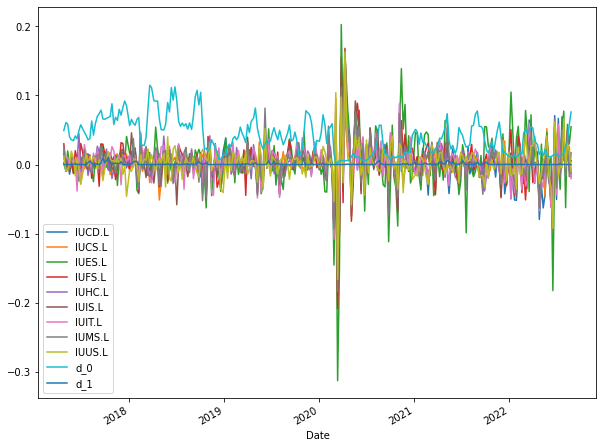

In [94]:
_ = df_a_t.plot(figsize=(10,8))

By eye it looks like there is a change in the 0th order homology at the March 2020 COVID crash

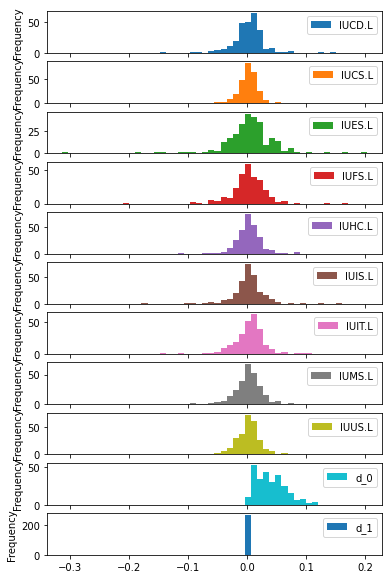

In [82]:
_ = df_a_t.plot(kind='hist', subplots=True, figsize=(6, 10), bins=50)

See if there are any obvious changes in the correlation structure

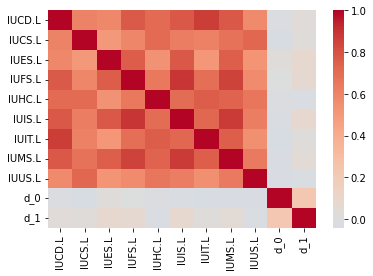

In [84]:
_ = sns.heatmap(df_a_t.corr(), cmap='coolwarm', center=0)

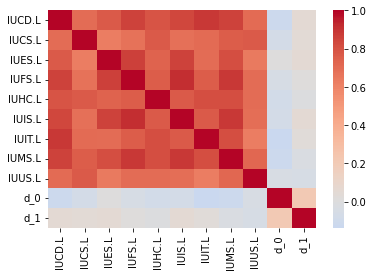

In [85]:
_ = sns.heatmap(df_a_t.loc['2018':'2020', :].corr(), cmap='coolwarm', center=0)

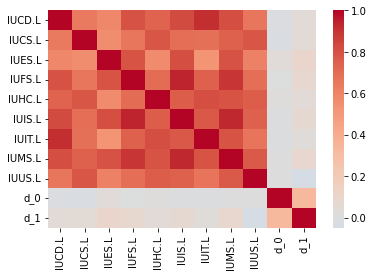

In [86]:
_ = sns.heatmap(df_a_t.loc['2020':, :].corr(), cmap='coolwarm', center=0)

Maybe a hint of the correlation between topological features and sector returns increasing after the crash?

Next to try: topological features as a leading indicator (the RandomForestRegressor part of the tutorial)